---
# Part1 資料清理、特徵工程
### Setup
[Top](#Table-of-Contents)

#### 匯入所需Python套件

In [1]:
#需自行安裝
# pip install -U imbalanced-lear
# pip install collinearity
# pip install reliability
# pip install xgboost
# 01 一般使用套件
import pandas as pd
import numpy as np
import datetime, os, re
from collections import Counter
from tqdm.notebook import tqdm as tqdm
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')

# 02 畫圖套件
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
import plotly.express as px


# 03 資料處理套件
from imblearn.over_sampling import SMOTE, KMeansSMOTE, BorderlineSMOTE #需自行安裝pip install -U imbalanced-lear
import sklearn
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, mutual_info_classif
from collinearity import SelectNonCollinear #需自行安裝pip install collinearity
from reliability.Probability_plotting import Normal_probability_plot #需自行安裝pip install reliability
from reliability.Probability_plotting import Normal_Distribution


# 04 巨量資料處理套件
# import multiprocessing
# from dask import dataframe as dd

# 05 機器學習套件
import xgboost as xgb #需自行安裝pip install xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn import tree, preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RepeatedStratifiedKFold

# 06 jupyter 輸出顯示設定
from IPython.display import display, Markdown, Image #required for well-formatted output from Notebook cells
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# 07 現在目錄位址
os.chdir('C:\\Users\\chiahaowang\\Documents\\PythonCode\\LossData')
base_dir = os.getcwd().replace('04_scripts', '')
base_dir

'C:\\Users\\chiahaowang\\Documents\\PythonCode\\LossData'

#### 自定義Python函式

In [ ]:
def parallel_processing(df, func):
    # 確定可用的CPU核心數量，留出一個核心以免凍結機器
    num_cores = multiprocessing.cpu_count() - 1 # leave one free to not freeze machine
     # 將DataFrame分割成等份，根據核心數量進行分割
    df_split = np.array_split(df, num_cores)
    
    pool = multiprocessing.Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    
    pool.close()
    pool.join()
    
    return df


def calculate_slope(df):
    copy = df.copy()
    
    # 初始化一個empty dataframe
    account_id_list = list(copy['玩家帳號'].unique())
    feature_list = list(copy.columns)
    feature_list.remove('玩家帳號')
    feature_list.remove('周次')
    slope = pd.DataFrame(index = account_id_list, columns = feature_list)
    slope.fillna(value = np.nan, inplace = True)
    
    # 逐account id計算斜率值
    for index, row in slope.iterrows():
        account = copy[copy['玩家帳號'] == index]
        try:
            for i in feature_list:
                slope.loc[index, i] = np.polyfit(account['周次'], account[i], 1)[0]
        except:
            slope.loc[index, i] = 0
    return slope


def standardize_slope(df):
    copy = df.copy()
    
    columns = list(copy.columns)
    columns.remove('玩家帳號')
    
    #對每列進行標準化
    for c in columns:
        copy[c + '_abs'] = abs(copy[c])
        copy[c + '_rank'] = copy[c + '_abs'].rank(method = 'min', pct = True)
        copy[c + '_std'] = np.where(copy[c] < 0 , round(copy[c + '_rank'], 2) * (-1), round(copy[c + '_rank'], 2))
        del copy[c]
        del copy[c + '_abs']
        del copy[c + '_rank'] 
        copy.rename(columns = {c + '_std':c}, inplace = True)
        
    return copy

# 將特徵名稱與來源信息寫入CSV文件
def write_feature_name(df, source):
    with open(r'C:\Users\chiahaowang\Documents\PythonCode\LossData\features.csv', mode='a', encoding='utf-8') as file:
        columns = list(df.columns)
        columns.remove('玩家帳號')
        for i in list(columns):
            file.write(f'{i},{source}\n')

#### 設定觀察期、表現期各別的起日、迄日

In [ ]:
obs_start_date_wg = widgets.DatePicker(description = '觀察期起日：', disabled = False)
obs_start_date_wg.value = datetime.date(2024, 8, 20)
obs_start_date_wg

In [ ]:
obs_end_date_wg = widgets.DatePicker(description = '觀察期迄日：', disabled = False)
obs_end_date_wg.value = datetime.date(2024, 9, 2)
obs_end_date = obs_end_date_wg.value  # 取得選擇的日期
obs_week_number = obs_end_date.isocalendar()[1]  # 計算是該年的第幾週
obs_end_date_wg

In [ ]:
perf_start_date_wg = widgets.DatePicker(description = '表現期起日：', disabled = False)
perf_start_date_wg.value = datetime.date(2024, 9, 17)
perf_start_date_wg

In [ ]:
perf_end_date_wg = widgets.DatePicker(description = '表現期迄日：', disabled = False)
perf_end_date_wg.value = datetime.date(2024, 9, 30)
perf_end_date_wg

In [ ]:
obs_start_date = obs_start_date_wg.value
obs_end_date = obs_end_date_wg.value
perf_start_date = perf_start_date_wg.value
perf_end_date = perf_end_date_wg.value

---
### 00_帳號登入資料
##### sessionActive.csv-> 變數處理-> target.parquet
[Top](#Table-of-Contents)

#### 決定目標玩家，以及是否流失的二元註記

In [ ]:
%%time
# Wall time: 7.3 s
    
# 01 讀取CSV資料
df_01 = pd.read_csv(base_dir + r'\02_raw_data\01_sessionActive\sessionActive.csv',
                    dtype = {'transferUID': 'object', 'LoginTimes': 'int8'},
                    parse_dates = ['LoginDate'])

df_01.rename(
    inplace = True,
    columns = {
        'LoginDate':'登入日期',
        'transferUID':'玩家帳號',
        'LoginTimes':'登入次數'
    }    
)


# 02 特徵處理
## 篩選出於觀察期有登入紀錄的玩家
df_01_obs = df_01.copy()
df_01_obs = df_01_obs[df_01_obs['登入次數'] > 0]
df_01_obs = df_01_obs[(obs_start_date <= df_01_obs['登入日期'].dt.date) & (df_01_obs['登入日期'].dt.date <= obs_end_date)]
df_01_obs_uni = pd.DataFrame(df_01_obs.玩家帳號.unique(), columns=['玩家帳號'])

## 篩選出於表現期有登入紀錄的玩家
df_01_perf = df_01.copy()
df_01_perf = df_01_perf[(perf_start_date <= df_01_perf['登入日期'].dt.date) & (df_01_perf['登入日期'].dt.date <= perf_end_date)]
df_01_perf_uni = pd.DataFrame(df_01_perf.玩家帳號.unique(), columns=['玩家帳號'])

## 左聯集即為建模使用的目標玩家
target = pd.merge(df_01_obs_uni, df_01_perf_uni, on = '玩家帳號', how = 'left', indicator = True)
target['是否流失'] = target['_merge'].apply(lambda x: '是' if x == 'left_only' else '否')
del target['_merge']


# 03 儲存特徵資料(原先為註解)
target.to_parquet(base_dir + r'\03_feature_data\target.parquet', index = False)


# 04 呈現資料Shape
# target = pd.read_parquet(base_dir + r'\03_feature_data\target.parquet')

print(f'資料筆數: {target.shape[0]:,}\n欄位數量: {target.shape[1]:}')
print(f'流失比例: {Counter(target["是否流失"]).get("是") / target.shape[0]:.2%}')

target.head()

---
### 01_帳號登入資料
##### sessionActive.csv-> 特徵處理-> feature_01.parquet
[Top](#Table-of-Contents)

In [ ]:

%%time
# Wall time: 1h 4min
# pip install fastparquet
# pip install pyarrow    
# 01 讀取CSV資料
df_01 = pd.read_csv(base_dir + r'\02_raw_data\01_sessionActive\sessionActive.csv',
                    dtype = {'transferUID': 'object', 'LoginTimes': 'int8'},
                    parse_dates = ['LoginDate'])

df_01.rename(
    inplace = True,
    columns = {
        'LoginDate':'登入日期',
        'transferUID':'玩家帳號',
        'LoginTimes':'登入次數'
    }    
)

target = pd.read_parquet(base_dir + r'\03_feature_data\target.parquet')
del target['是否流失']


# 02 特徵處理
df_01_copy = df_01.copy()
df_01_copy = df_01_copy[df_01_copy['登入次數'] > 0]
# df_01_copy = df_01.sample(n = 10000)

## 排除掉非目標玩家，排除掉觀察期以外的資料
df_01_copy = pd.merge(target, df_01_copy, on = '玩家帳號', how = 'inner')
df_01_copy = df_01_copy[(obs_start_date <= df_01_copy['登入日期'].dt.date) & (df_01_copy['登入日期'].dt.date <= obs_end_date)]

df_01_copy['周次'] = df_01_copy['登入日期'].dt.isocalendar().week

## 新增特徵: 前第n周量測值，n = 1, 2, 3, 4
df_01_agg = df_01_copy.groupby(['玩家帳號', '周次']).agg({'登入日期':pd.Series.nunique, '登入次數':pd.Series.sum})
df_01_agg.rename(columns = {'登入日期': '登入天數'}, inplace = True)
df_01_agg.reset_index(inplace = True)
df_01_agg['平均日登入次數'] = (df_01_agg['登入天數'] / df_01_agg['登入次數']).round(decimals = 1)

df_01_pivot = df_01_agg.pivot_table(
    index      = ['玩家帳號'], 
    columns    = ['周次'], 
    values     = ['登入天數', '登入次數', '平均日登入次數'], 
    aggfunc    = 'sum', 
    fill_value = 0)

prefix = ['前第' + str(obs_week_number - i) + '周' for i in df_01_pivot.columns.get_level_values(1)]
column_name = df_01_pivot.columns.get_level_values(0)
df_01_pivot.columns = prefix + column_name
df_01_pivot.reset_index(inplace = True)

## 新增特徵: 前1月xxx的周斜率
df_01_slope = calculate_slope(df_01_agg)
df_01_slope.reset_index(inplace = True)
df_01_slope.rename(
    inplace = True,
    columns = {
        'index':'玩家帳號', 
        '登入天數':'前1月登入天數的周斜率',
        '登入次數':'前1月登入次數的周斜率', 
        '平均日登入次數':'前1月平均日登入次數的周斜率'
    }    
)

df_01_slope = standardize_slope(df_01_slope)


## 歸戶至目標玩家
feature_01 = pd.merge(target, df_01_pivot, on = '玩家帳號', how = 'left')
feature_01 = pd.merge(feature_01, df_01_slope, on = '玩家帳號', how = 'left')
feature_01.fillna(value = 0, inplace = True)

# 03 儲存特徵資料
feature_01.to_parquet(base_dir + r'\03_feature_data\feature_01.parquet', index = False)


# 04 呈現資料Shape
# feature_01 = pd.read_parquet(base_dir + r'\03_feature_data\feature_01.parquet')

print(f'資料筆數: {feature_01.shape[0]:,}\n欄位數量: {feature_01.shape[1]:}')

feature_01.head()

---
### 02_帳號創建資料
##### accountCreate.csv-> 特徵處理-> feature_02.parquet
[Top](#Table-of-Contents)

In [ ]:
%%time
# Wall time: 1.01 s

# 01 讀取CSV資料
df_02 = pd.read_csv(base_dir + r'\02_raw_data\02_accountCreate\accountCreate.csv',
                    dtype = {'transferUID': 'object', 'Channel': 'object', 'OpenType': 'object'},
                    parse_dates = ['CreateDate'])

df_02_channel = pd.read_csv(base_dir + r'\02_raw_data\02_accountCreate\accountCreate_channel.csv',
                            dtype = {'ChannelKey': 'object'})

df_02_optnType = pd.read_csv(base_dir + r'\02_raw_data\02_accountCreate\accountCreate_optnType.csv',
                             dtype = {'ThirdPartyType': 'object'})

df_02.rename(
    inplace = True,
    columns = {
        'CreateDate':'建立日期',
        'transferUID':'玩家帳號',
        'Channel':'下載平台',
        'OpenType':'登入平台'
    }    
)

dict_02_channel = df_02_channel.set_index('ChannelKey')['ChannelName'].to_dict()
dict_02_optnType = df_02_optnType.set_index('ThirdPartyType')['ThirdPartyTypeName'].to_dict()

target = pd.read_parquet(base_dir + r'\03_feature_data\target.parquet')
del target['是否流失']


# 02 特徵處理
df_02_copy = df_02.copy()

df_02_copy['下載平台'] = df_02_copy['下載平台'].map(dict_02_channel)
df_02_copy['登入平台'] = df_02_copy['登入平台'].map(dict_02_optnType)
df_02_copy['是否於觀察期註冊'] = df_02_copy['建立日期'].apply(lambda x: '是' if (obs_start_date <= x.date()) & (x.date() <= obs_end_date) else '否')
df_02_copy['是否於近6個月註冊'] = df_02_copy['建立日期'].apply(lambda x: '是' if (obs_end_date - x.date()).days >= 180 else '否')
del df_02_copy['建立日期']

## 移除重複且不一致的資料
df_02_dup = df_02_copy.groupby(['玩家帳號']).size().reset_index(name='counts')
df_02_dup = df_02_dup[df_02_dup['counts'] > 1]
df_02_dup = pd.merge(df_02_dup, df_02_copy, on = '玩家帳號', how = 'left')
# df_02_dup
list_duplicates = list(df_02_dup['玩家帳號'])
df_02_dedu = df_02_copy[~df_02_copy['玩家帳號'].isin(list_duplicates)]

## 歸戶至目標玩家
feature_02 = pd.merge(target, df_02_dedu, on = '玩家帳號', how = 'left')
feature_02.fillna(value = '沒有紀錄', inplace = True)


# 03 儲存特徵資料
feature_02.to_parquet(base_dir + r'\03_feature_data\feature_02.parquet', index = False)


# 04 呈現資料Shape
# feature_02 = pd.read_parquet(base_dir + r'\新語法\Input_data\03_feature_data\feature_02.parquet')


print(f'資料筆數: {feature_02.shape[0]:,}\n欄位數量: {feature_02.shape[1]:}')

feature_02.head()

---
### 03_遊戲時長資料
##### sessionLength.csv-> 特徵處理-> feature_03.parquet
[Top](#Table-of-Contents)

In [ ]:
%%time 
# Wall time: 43min 41s
    
# 01 讀取CSV資料
df_03 = pd.read_csv(base_dir + r'\02_raw_data\03_sessionLength\sessionLength.csv',
                    dtype = {'transferUID': 'object', 'GameID': 'object', 'Min': 'int16'},
                    parse_dates = ['StartTime', 'EndTime'])

df_03.rename(
    inplace = True,
    columns = {
        'transferUID':'玩家帳號',
        'GameID':'遊戲代號',
        'StartTime':'開始時間',
        'EndTime':'結束時間',
        'Min':'遊玩時間長度'
    }    
)

df_03_gameId = pd.read_csv(base_dir + r'\02_raw_data\03_sessionLength\sessionLength_gameId.csv', dtype = {'GameKey': 'object'}, encoding = 'Big5')
dict_03_gameName = df_03_gameId.set_index('GameKey')['GameName'].to_dict()
dict_03_gameType = df_03_gameId.set_index('GameKey')['GameType'].to_dict()

target = pd.read_parquet(base_dir + r'\03_feature_data\target.parquet')
del target['是否流失']


# 02 特徵處理
df_03_copy = df_03.copy()
# df_03_copy = df_03.sample(n = 10000)

## 排除掉非目標玩家，排除掉觀察期以外的資料
df_03_copy = pd.merge(target, df_03_copy, on = '玩家帳號', how = 'inner')
df_03_copy = df_03_copy[(obs_start_date <= df_03_copy['開始時間'].dt.date) & (df_03_copy['開始時間'].dt.date <= obs_end_date)]

df_03_copy['遊戲名稱'] = df_03_copy['遊戲代號'].map(dict_03_gameName)
df_03_copy['遊戲類型'] = df_03_copy['遊戲代號'].map(dict_03_gameType)
df_03_copy['遊戲名稱'].fillna('沒有紀錄', inplace = True)
df_03_copy['遊戲類型'].fillna('沒有紀錄', inplace = True)

df_03_copy['周次'] = df_03_copy['開始時間'].dt.isocalendar().week
df_03_copy['日期'] = df_03_copy['開始時間'].dt.date
del df_03_copy['開始時間']
del df_03_copy['結束時間']

## 新增特徵: 前第n周量測值，n = 1, 2, 3, 4
df_03_agg = df_03_copy.groupby(['玩家帳號', '周次']).agg({'日期':pd.Series.nunique, '遊玩時間長度':pd.Series.sum})
df_03_agg.rename(columns = {'日期': '遊玩天數'}, inplace = True)
df_03_agg.reset_index(inplace = True)
df_03_agg['平均日遊玩時間長度'] = (df_03_agg['遊玩時間長度'] / df_03_agg['遊玩天數']).round(decimals = 1)

df_03_pivot = df_03_agg.pivot_table(
    index      = ['玩家帳號'], 
    columns    = ['周次'], 
    values     = ['遊玩天數', '遊玩時間長度', '平均日遊玩時間長度'], 
    aggfunc    = 'sum', 
    fill_value = 0)

prefix = ['前第' + str(obs_week_number - i) + '周' for i in df_03_pivot.columns.get_level_values(1)]
column_name = df_03_pivot.columns.get_level_values(0)
df_03_pivot.columns = prefix + column_name
df_03_pivot.reset_index(inplace = True)

## 新增特徵: 前1月xxx的周斜率
df_03_slope = calculate_slope(df_03_agg)
df_03_slope.reset_index(inplace = True)
df_03_slope.rename(
    inplace = True,
    columns = {
        'index':'玩家帳號', 
        '遊玩天數':'前1月遊玩天數的周斜率',
        '遊玩時間長度':'前1月遊玩時間長度的周斜率',
        '平均日遊玩時間長度':'前1月平均日遊玩時間長度的周斜率'
    }    
)

df_03_slope = standardize_slope(df_03_slope)


## 歸戶至目標玩家
feature_03 = pd.merge(target, df_03_pivot, on = '玩家帳號', how = 'left')
feature_03 = pd.merge(feature_03, df_03_slope, on = '玩家帳號', how = 'left')
feature_03.fillna(value = 0, inplace = True)


# 03 儲存特徵資料
feature_03.to_parquet(base_dir + r'\03_feature_data\feature_03.parquet', index = False)


# 04 呈現資料Shape
# feature_03 = pd.read_parquet(base_dir + r'\03_feature_data\feature_03.parquet')

print(f'資料筆數: {feature_03.shape[0]:,}\n欄位數量: {feature_03.shape[1]:}')

feature_03.head()

---
### 04_遊戲押注紀錄
##### betRecords.csv-> 特徵處理-> feature_04.parquet
[Top](#Table-of-Contents)

In [ ]:
%%time
# Wall time: 50min 56s

# 01 讀取CSV資料
df_04 = pd.read_csv(base_dir + r'\02_raw_data\04_betRecords\betRecords.csv',
                    parse_dates = ['DateKey'],
                    dtype = {
                        'transferUID':'object'})
                        # 'GameID': 'object'
                        # 'MachineType': 'object'
df_04.rename(
    inplace = True,
    columns = {
        'DateKey':'日期',
        'transferUID':'玩家帳號',
        # 'GameID':'遊戲代號',
        # 'MachineType':'機台類型',
        'Counts':'押注次數',
        'RatioTotalWin':'總贏金幣',
        'RatioTotalBet':'總押金幣',
        # '平台JP總贏金幣':'Jackpot金幣'
    }
)

target = pd.read_parquet(base_dir + r'\03_feature_data\target.parquet')
del target['是否流失']


# 02 特徵處理
df_04_copy = df_04.copy()
# df_04_copy = df_04.sample(n = 10000)

## 排除掉非目標玩家，排除掉觀察期以外的資料
df_04_copy = pd.merge(target, df_04_copy, on = '玩家帳號', how = 'left')
df_04_copy = df_04_copy[(obs_start_date <= df_04_copy['日期'].dt.date) & (df_04_copy['日期'].dt.date <= obs_end_date)]

df_04_copy['周次'] = df_04_copy['日期'].dt.isocalendar().week
del df_04_copy['日期']
# del df_04_copy['Jackpot金幣']

## 新增特徵: 前第n周量測值，n = 1, 2, 3, 4
df_04_agg = df_04_copy.groupby(['玩家帳號', '周次']).agg({'押注次數':pd.Series.sum, '總押金幣':pd.Series.sum, '總贏金幣':pd.Series.sum})
df_04_agg['單周報酬率'] = (df_04_agg['總贏金幣'] / df_04_agg['總押金幣']).round(decimals = 4)
df_04_agg['平均押注金額'] = (df_04_agg['總押金幣'] / df_04_agg['押注次數']).round(decimals = 0)
df_04_agg.reset_index(inplace = True)

df_04_pivot = df_04_agg.pivot_table(
    index      = ['玩家帳號'], 
    columns    = ['周次'], 
    values     = ['押注次數', '平均押注金額', '單周報酬率'], 
    aggfunc    = 'sum', 
    fill_value = 0)

prefix = ['前第' + str(obs_week_number - i) + '周' for i in df_04_pivot.columns.get_level_values(1)]
column_name = df_04_pivot.columns.get_level_values(0)
df_04_pivot.columns = prefix + column_name
df_04_pivot.reset_index(inplace = True)

## 新增特徵: 前1月xxx的周斜率
df_04_slope = calculate_slope(df_04_agg)

df_04_slope.reset_index(inplace = True)
df_04_slope.rename(
    inplace = True,
    columns = {
        'index':'玩家帳號', 
        '押注次數':'前1月押注次數的周斜率', 
        '平均押注金額':'前1月平均押注金額的周斜率',
        '單周報酬率':'前1月單周報酬率的周斜率',
        '總押金幣':'前1月總押金幣的周斜率', 
        '總贏金幣':'前1月總贏金幣的周斜率'
    }    
)

df_04_slope = standardize_slope(df_04_slope)

## 歸戶至目標玩家
feature_04 = pd.merge(target, df_04_pivot, on = '玩家帳號', how = 'left')
feature_04 = pd.merge(feature_04, df_04_slope, on = '玩家帳號', how = 'left')
feature_04.fillna(value = 0, inplace = True)


# 03 儲存特徵資料
feature_04.to_parquet(base_dir + r'\03_feature_data\feature_04.parquet', index = False)


# 04 呈現資料Shape
# feature_04 = pd.read_parquet(base_dir + r'\03_feature_data\feature_04.parquet')

print(f'資料筆數: {feature_04.shape[0]:,}\n欄位數量: {feature_04.shape[1]:}')

feature_04.head()

---
## 05_金幣進出紀錄
##### coinRecords.csv-> 特徵處理-> feature_05.parquet
[Top](#Table-of-Contents)

In [ ]:
%%time
#05_金幣進出紀錄
# Wall time: 34.3min

# 01 讀取CSV資料
df_05 = pd.read_csv(base_dir + r'\02_raw_data\05_coinRecords\coinRecords.csv',
                    parse_dates = ['CreateDate'],
                    dtype = {
                        'transferUID': 'object', 
                        'Reason': 'object',
                        'IncreaseCoins': 'float32',
                        'DecreaseCoins': 'float32',
                        'ReasonTimes': 'float32'})
df_05.rename(
    inplace = True, 
    columns = {
        'CreateDate':'日期',
        'transferUID':'玩家帳號',
        'Reason':'事件代號',
        'IncreaseCoins':'增加金幣',
        'DecreaseCoins':'減少金幣',
        'ReasonTimes':'發生次數'
    }
)

df_05_reason = pd.read_csv(base_dir + r'\02_raw_data\05_coinRecords\coinRecords_reason.csv', dtype = {'ReasonKey': 'object'}, encoding = 'Big5')
df_05_reason['Group'] = df_05_reason['Group'].apply(lambda x: re.split(':', x)[1])
dict_05_reason = df_05_reason.set_index('ChangeReasonName')['Group'].to_dict()
#原始Code  dict_05_reason = df_05_reason.set_index('ReasonKey')['Group'].to_dict()

target = pd.read_parquet(base_dir + r'\03_feature_data\target.parquet')
del target['是否流失']


# 02 特徵處理
df_05_copy = df_05.copy()
# df_05_copy = df_05.sample(n = 10000)

## 排除掉非目標玩家，排除掉觀察期以外的資料
df_05_copy = pd.merge(target, df_05_copy, on = '玩家帳號', how = 'inner')
df_05_copy = df_05_copy[(obs_start_date <= df_05_copy['日期'].dt.date) & (df_05_copy['日期'].dt.date <= obs_end_date)]

df_05_copy['周次'] = df_05_copy['日期'].dt.isocalendar().week
del df_05_copy['日期']

df_05_copy['事件'] = df_05_copy['事件代號'].map(dict_05_reason)
del df_05_copy['事件代號']

df_05_copy.fillna(0)
df_05_copy.replace(np.nan, 0)
df_05_copy['金幣變化'] = (df_05_copy['增加金幣'] - df_05_copy['減少金幣']).round(decimals = 0)
df_05_copy['金幣變化'] = df_05_copy['金幣變化'].astype('float32')

del df_05_copy['增加金幣']
del df_05_copy['減少金幣']

## 新增特徵: 前第n周量測值，n = 1, 2, 3, 4
df_05_agg = df_05_copy.groupby(['玩家帳號', '周次', '事件']).agg({'發生次數':pd.Series.sum, '金幣變化':pd.Series.sum})
df_05_agg.reset_index(inplace = True)

df_05_pivot = df_05_agg.pivot_table(
    index      = ['玩家帳號'], 
    columns    = ['周次', '事件'], 
    values     = ['發生次數', '金幣變化'],
    aggfunc    = 'sum', 
    fill_value = 0)

tmp1 = ['前第' + str(obs_week_number - i) + '周' for i in df_05_pivot.columns.get_level_values(1)]
tmp2 = list(df_05_pivot.columns.get_level_values(2))
tmp3 = list(df_05_pivot.columns.get_level_values(0))
df_05_pivot.columns = [x1 + x2 + '的' + x3 for x1, x2, x3 in zip(tmp1, tmp2, tmp3)]
df_05_pivot.reset_index(inplace = True)

## 新增特徵: 前1月xxx的周斜率
df_05_pivot2 = df_05_agg.pivot_table(
    index      = ['玩家帳號', '周次'], 
    columns    = ['事件'], 
    values     = ['發生次數', '金幣變化'], 
    aggfunc    = 'sum', 
    fill_value = 0)

tmp1 = list(df_05_pivot2.columns.get_level_values(1))
tmp2 = list(df_05_pivot2.columns.get_level_values(0))
df_05_pivot2.columns = [x1 + '的' + x2 for x1, x2 in zip(tmp1, tmp2)]
df_05_pivot2.reset_index(inplace = True)

df_05_slope = calculate_slope(df_05_pivot2)
df_05_slope.reset_index(inplace = True)
df_05_slope.rename(
    inplace = True, 
    columns = {
        'index':'玩家帳號'
    }   
)
df_05_slope = standardize_slope(df_05_slope)

tmp1 = list(df_05_slope.columns)
tmp1.remove('玩家帳號')
tmp2 = ['前1月' + x + '的周斜率' for x in tmp1]
tmp2 = ['玩家帳號'] + tmp2
df_05_slope.columns = tmp2

## 歸戶至目標玩家
feature_05 = pd.merge(target, df_05_pivot, on = '玩家帳號', how = 'left')
feature_05 = pd.merge(feature_05, df_05_slope, on = '玩家帳號', how = 'left')
feature_05.fillna(value = 0, inplace = True)


# 03 儲存特徵資料
feature_05.to_parquet(base_dir + r'\03_feature_data\feature_05.parquet', index = False)


# 04 呈現資料Shape
# feature_05 = pd.read_parquet(base_dir + r'\03_feature_data\feature_05.parquet')

print(f'資料筆數: {feature_05.shape[0]:,}\n欄位數量: {feature_05.shape[1]:}')

feature_05.head()

---
### 06_轉帳交易紀錄
##### txnRecords.csv-> 特徵處理-> feature_06.parquet
[Top](#Table-of-Contents)

In [ ]:
%%time
#06_轉帳交易紀錄
# Wall time: 39 s

# 01 讀取CSV資料
df_06 = pd.read_csv(
    base_dir + r'\02_raw data\06_txnRecords\txnRecords.csv',
    parse_dates = ['CreateDate'],
    dtype = {
        'Status': 'object', 
        'TransmitCoin': 'int32', 
        'TransmitFee': 'int32',
        'TtransferUID': 'object',
        'RtransferUID': 'object'
    }
)

df_06.rename(
    inplace = True, 
    columns = {
        'CreateDate':'日期',
        'Status': '交易狀態', 
        'TransmitCoin':'交易金額',
        'TransmitFee':'交易手續費',
        'TtransferUID':'轉出玩家帳號',
        'RtransferUID':'轉入玩家帳號'
    }    
)

df_06_status = pd.read_csv(base_dir + r'\02_raw data\06_txnRecords\txnRecords_status.csv', dtype = {'StatusKey': 'object'})
dict_06_status = df_06_status.set_index('StatusKey')['StatusName'].to_dict()

target = pd.read_parquet(base_dir + r'\03_feature_data\target.parquet')
del target['是否流失']


# 02 特徵處理
df_06_copy = df_06.copy()
# df_06_copy = df_06.sample(n = 10000)

## 排除掉非目標玩家，排除掉觀察期以外的資料
df_06_copy = df_06_copy[(obs_start_date <= df_06_copy['日期'].dt.date) & (df_06_copy['日期'].dt.date <= obs_end_date)]
df_06_copy = df_06_copy[(df_06_copy['交易狀態'] != '0') & (df_06_copy['交易狀態'] != '1')]

df_06_copy['周次'] = df_06_copy['日期'].dt.isocalendar().week

## 新增特徵: 前第n周量測值，n = 1, 2, 3, 4
df_06_out = df_06_copy.copy()
df_06_out['交易結果'] = df_06_out['交易狀態'].apply(lambda x: '成功轉出' if x == '3' else '失敗轉出')
df_06_out = df_06_out.groupby(['轉出玩家帳號', '周次', '交易結果']).agg({'交易金額':pd.Series.sum, '日期':pd.Series.nunique})
df_06_out.reset_index(inplace = True)
df_06_out.rename(columns = {'轉出玩家帳號': '玩家帳號', '日期': '發生天數'}, inplace = True)
df_06_out['交易金額'] = df_06_out['交易金額'] * (-1)

df_06_in = df_06_copy.copy()
df_06_in['交易結果'] = df_06_in['交易狀態'].apply(lambda x: '成功轉入' if x == '3' else '失敗轉入')
df_06_in = df_06_in.groupby(['轉入玩家帳號', '周次', '交易結果']).agg({'交易金額':pd.Series.sum, '日期':pd.Series.nunique})
df_06_in.reset_index(inplace = True)
df_06_in.rename(columns = {'轉入玩家帳號': '玩家帳號', '日期': '發生天數'}, inplace = True)

df_06_concat = pd.concat([df_06_in, df_06_out])

df_06_pivot = df_06_concat.pivot_table(
    index      = ['玩家帳號'], 
    columns    = ['周次', '交易結果'], 
    values     = ['交易金額', '發生天數'], 
    aggfunc    = 'sum', 
    fill_value = 0)

tmp1 = ['前第' + str(obs_week_number - i) + '周' for i in df_06_pivot.columns.get_level_values(1)]
tmp2 = [x + '的' for x in df_06_pivot.columns.get_level_values(2)]
tmp3 = list(df_06_pivot.columns.get_level_values(0))
df_06_pivot.columns = [x1 + x2 + x3 for x1, x2, x3 in zip(tmp1, tmp2, tmp3)]
df_06_pivot.reset_index(inplace = True)

## 新增特徵: 前1月xxx的周斜率
df_06_pivot2 = df_06_concat.pivot_table(
    index      = ['玩家帳號', '周次'], 
    columns    = ['交易結果'], 
    values     = ['交易金額', '發生天數'], 
    aggfunc    = 'sum', 
    fill_value = 0)

tmp1 = list(df_06_pivot2.columns.get_level_values(1))
tmp2 = list(df_06_pivot2.columns.get_level_values(0))
df_06_pivot2.columns = [x1 + '的' + x2 for x1, x2 in zip(tmp1, tmp2)]
df_06_pivot2.reset_index(inplace = True)

df_06_slope = calculate_slope(df_06_pivot2)
df_06_slope.reset_index(inplace = True)
df_06_slope.rename(
    inplace = True, 
    columns = {
        'index':'玩家帳號'
    }   
)
df_06_slope = standardize_slope(df_06_slope)

tmp1 = list(df_06_slope.columns)
tmp1.remove('玩家帳號')
tmp2 = ['前1月' + x + '的周斜率' for x in tmp1]
tmp2 = ['玩家帳號'] + tmp2
df_06_slope.columns = tmp2

## 歸戶至目標玩家
feature_06 = pd.merge(target, df_06_pivot, on = '玩家帳號', how = 'left')
feature_06 = pd.merge(feature_06, df_06_slope, on = '玩家帳號', how = 'left')
feature_06.fillna(value = 0, inplace = True)


# 03 儲存特徵資料
feature_06.to_parquet(base_dir + r'\03_feature_data\feature_06.parquet', index = False)


# 04 呈現資料Shape
# feature_06 = pd.read_parquet(base_dir + r'\03_feature_data\feature_06.parquet')

print(f'資料筆數: {feature_06.shape[0]:,}\n欄位數量: {feature_06.shape[1]:}')

feature_06.head()

---
### 07_儲值紀錄
##### depositRecords.csv-> 特徵處理-> feature_07.parquet
[Top](#Table-of-Contents)

In [ ]:
%%time
#07_儲值紀錄
# Wall time: 1min 23s

# 01 讀取CSV資料
df_07 = pd.read_csv(
    base_dir + r'\02_raw_data\07_depositRecords\depositRecords.csv',
    parse_dates = ['CreateDate'],
    dtype = {
        'transferUID': 'object'
    }
)

df_07.rename(
    columns = {
        'CreateDate': '日期', 
        'transferUID': '玩家帳號', 
        'BuyNumber': '儲值金額', 
        'CoinAfter': '儲值前餘額',
        'CoinBefore': '儲值後餘額'
    },
    inplace = True
)

target = pd.read_parquet(base_dir + r'\03_feature_data\target.parquet')
del target['是否流失']


# 02 特徵處理
df_07_copy = df_07.copy()
# df_07_copy = df_07.sample(n = 10000)

## 排除掉非目標玩家，排除掉觀察期以外的資料
df_07_copy = pd.merge(target, df_07_copy, on = '玩家帳號', how = 'inner')
df_07_copy = df_07_copy[(obs_start_date <= df_07_copy['日期'].dt.date) & (df_07_copy['日期'].dt.date <= obs_end_date)]

df_07_copy['周次'] = df_07_copy['日期'].dt.isocalendar().week
del df_07_copy['日期']

## 新增特徵: 前第n周量測值，n = 1, 2, 3, 4
df_07_agg = df_07_copy.groupby(['玩家帳號', '周次']).agg({'儲值金額':pd.Series.sum, '儲值前餘額':[np.min, np.mean]})
df_07_agg.reset_index(inplace = True)
df_07_agg.columns = df_07_agg.columns.get_level_values(0) + df_07_agg.columns.get_level_values(1)
df_07_agg.rename(
    inplace = True,
    columns = {
        '儲值金額sum': '儲值金額', 
        '儲值前餘額min': '最小餘額',
        '儲值前餘額mean':'平均餘額'
    }
)

df_07_pivot = df_07_agg.pivot_table(
    index      = ['玩家帳號'], 
    columns    = ['周次'], 
    values     = ['儲值金額', '最小餘額', '平均餘額'], 
    aggfunc    = 'sum', 
    fill_value = 0)

tmp1 = ['前第' + str(obs_week_number - i) + '周' for i in df_07_pivot.columns.get_level_values(1)]
tmp2 = list(df_07_pivot.columns.get_level_values(0))
df_07_pivot.columns = [x1 + x2 for x1, x2 in zip(tmp1, tmp2)]
df_07_pivot.reset_index(inplace = True)

## 新增特徵: 前1月xxx的周斜率
df_07_slope = calculate_slope(df_07_agg)
df_07_slope.reset_index(inplace = True)
df_07_slope.rename(inplace = True, columns = {'index':'玩家帳號'})
df_07_slope = standardize_slope(df_07_slope)

tmp1 = list(df_07_slope.columns)
tmp1.remove('玩家帳號')
tmp2 = ['前1月' + x + '的周斜率' for x in tmp1]
tmp2 = ['玩家帳號'] + tmp2
df_07_slope.columns = tmp2

## 歸戶至目標玩家
feature_07 = pd.merge(target, df_07_pivot, on = '玩家帳號', how = 'left')
feature_07 = pd.merge(feature_07, df_07_slope, on = '玩家帳號', how = 'left')
feature_07.fillna(value = 0, inplace = True)


# 03 儲存特徵資料
feature_07.to_parquet(base_dir + r'\03_feature_data\feature_07.parquet', index = False)


# 04 呈現資料Shape
# feature_07 = pd.read_parquet(base_dir + r'\03_feature_data\feature_07.parquet')

print(f'資料筆數: {feature_07.shape[0]:,}\n欄位數量: {feature_07.shape[1]:}')

feature_07.head()

---
### 08_儲值退費紀錄
##### refundRecords.csv-> 特徵處理-> feature_08.parquet
[Top](#Table-of-Contents)

In [ ]:
%%time
# Wall time: 338 ms

# 01 讀取CSV資料
df_08 = pd.read_csv(
    base_dir + r'\02_raw_data\08_refundRecords\refundRecords.csv', 
    parse_dates = ['DoneTime'], 
    dtype = {'transferUID': 'object'}
)

del df_08['EventTime']
del df_08['VoidedTime']

df_08.rename(
    inplace = True,
    columns = {
        'DoneTime': '日期', 
        'transferUID': '玩家帳號',
        'OrderID':'訂單編號',
        'BuyNumber': '退費金額', 
        'Distributor': '儲值管道代碼'
    }
)

# df_08_distributor = pd.read_csv(base_dir + r'\02_raw_data\08_refundRecords\refundRecords_distributor.csv', 
#                                 dtype = {'DistributorKey': 'object'})

# dict_08_distributor = df_08_distributor.set_index('DistributorKey')['DistributorName'].to_dict()

target = pd.read_parquet(base_dir + r'\03_feature_data\target.parquet')
del target['是否流失']


# 02 特徵處理
df_08_copy = df_08.copy()

## 排除掉非目標玩家，排除掉觀察期以外的資料
df_08_copy = pd.merge(target, df_08_copy, on = '玩家帳號', how = 'inner')
df_08_copy = df_08_copy[(obs_start_date <= df_08_copy['日期'].dt.date) & (df_08_copy['日期'].dt.date <= obs_end_date)]

df_08_copy['周次'] = df_08_copy['日期'].dt.isocalendar().week
del df_08_copy['日期']

## 新增特徵: 前第n周量測值，n = 1, 2, 3, 4
df_08_agg = df_08_copy.groupby(['玩家帳號', '周次']).agg({'退費金額':pd.Series.sum, '訂單編號':pd.Series.nunique})
df_08_agg.reset_index(inplace = True)
df_08_agg.rename(
    inplace = True,
    columns = {
        '訂單編號': '退費次數'
    }
)

df_08_pivot = df_08_agg.pivot_table(
    index      = ['玩家帳號'], 
    columns    = ['周次'], 
    values     = ['退費金額', '退費次數'], 
    aggfunc    = 'sum', 
    fill_value = 0)

tmp1 = ['前第' + str(obs_week_number - i) + '周' for i in df_08_pivot.columns.get_level_values(1)]
tmp2 = list(df_08_pivot.columns.get_level_values(0))
df_08_pivot.columns = [x1 + x2 for x1, x2 in zip(tmp1, tmp2)]
df_08_pivot.reset_index(inplace = True)

## 新增特徵: 前1月是否退費
df_08_agg2 = df_08_agg.groupby(['玩家帳號']).agg({'退費次數':pd.Series.sum})
df_08_merge = pd.merge(target, df_08_agg2, on = '玩家帳號', how = 'left', indicator = True)
df_08_merge['前1月是否退費'] = df_08_merge['_merge'].apply(lambda x: '是' if x == 'left_only' else '否')
del df_08_merge['_merge']
df_08_refund = df_08_merge[['玩家帳號', '前1月是否退費']]

## 歸戶至目標玩家
feature_08 = pd.merge(df_08_refund, df_08_pivot, on = '玩家帳號', how = 'left')
feature_08.fillna(value = 0, inplace = True)


# 03 儲存特徵資料
feature_08.to_parquet(base_dir + r'\03_feature_data\feature_08.parquet', index = False)


# 04 呈現資料Shape
# feature_08 = pd.read_parquet(base_dir + r'\03_feature_data\feature_08.parquet')

print(f'資料筆數: {feature_08.shape[0]:,}\n欄位數量: {feature_08.shape[1]:}')

feature_08.head()

---
### 合併所有特徵
[Top](#Table-of-Contents)

In [9]:
features

['feature_01.parquet',
 'feature_02.parquet',
 'feature_03.parquet',
 'feature_04.parquet',
 'feature_05.parquet',
 'feature_07.parquet',
 'feature_08.parquet']

In [10]:
%%time

# 01 合併所有特徵
data = pd.read_parquet(base_dir + r'\03_feature_data\target.parquet')

features = os.listdir(base_dir + r'\03_feature_data')
features = list(filter(lambda f: f.startswith('feature_0'), features))
features.sort()

for f in features:
    fp = pd.read_parquet(base_dir + r'\03_feature_data\\' + f)
    data = pd.merge(data, fp, on = '玩家帳號', how = 'left')
    
# 02 儲存特徵資料
data.to_parquet(base_dir + r'\03_feature_data\data.parquet', index = False)
data.to_csv(base_dir + r'\03_feature_data\data.csv', index = False)

# 03 呈現資料Shape
print(f'資料筆數: {data.shape[0]:,}\n欄位數量: {data.shape[1]:}')

# data.head(10)

資料筆數: 32,813
欄位數量: 127
CPU times: total: 2.08 s
Wall time: 2.17 s


In [11]:
data.head()

,玩家帳號,是否流失,前第2周平均日登入次數,前第1周平均日登入次數,前第0周平均日登入次數,前第2周登入天數,前第1周登入天數,前第0周登入天數,前第2周登入次數,前第1周登入次數,前第0周登入次數,前1月登入天數的周斜率,前1月登入次數的周斜率,前1月平均日登入次數的周斜率,下載平台,登入平台,是否於觀察期註冊,是否於近6個月註冊,前第2周平均日遊玩時間長度,前第1周平均日遊玩時間長度,前第0周平均日遊玩時間長度,前第2周遊玩天數,前第1周遊玩天數,前第0周遊玩天數,前第2周遊玩時間長度,前第1周遊玩時間長度,前第0周遊玩時間長度,前1月遊玩天數的周斜率,前1月遊玩時間長度的周斜率,前1月平均日遊玩時間長度的周斜率,前第2周單周報酬率,前第1周單周報酬率,前第0周單周報酬率,前第2周平均押注金額,前第1周平均押注金額,前第0周平均押注金額,前第2周押注次數,前第1周押注次數,前第0周押注次數,前1月押注次數的周斜率,前1月總押金幣的周斜率,前1月總贏金幣的周斜率,前1月單周報酬率的周斜率,前1月平均押注金額的周斜率,前第2周儲值的發生次數,前第2周其它的發生次數,前第2周平台贈送的發生次數,前第2周登入贈送的發生次數,前第2周遊戲的發生次數,前第2周運營的發生次數,前第2周道具的發生次數,前第2周限時活動的發生次數,前第1周儲值的發生次數,前第1周其它的發生次數,前第1周平台贈送的發生次數,前第1周登入贈送的發生次數,前第1周遊戲的發生次數,前第1周運營的發生次數,前第1周道具的發生次數,前第1周限時活動的發生次數,前第0周儲值的發生次數,前第0周其它的發生次數,前第0周平台贈送的發生次數,前第0周登入贈送的發生次數,前第0周遊戲的發生次數,前第0周運營的發生次數,前第0周道具的發生次數,前第0周限時活動的發生次數,前第2周儲值的金幣變化,前第2周其它的金幣變化,前第2周平台贈送的金幣變化,前第2周登入贈送的金幣變化,前第2周遊戲的金幣變化,前第2周運營的金幣變化,前第2周道具的金幣變化,前第2周限時活動的金幣變化,前第1周儲值的金幣變化,前第1周其它的金幣變化,前第1周平台贈送的金幣變化,前第1周登入贈送的金幣變化,前第1周遊戲的金幣變化,前第1周運營的金幣變化,前第1周道具的金幣變化,前第1周限時活動的金幣變化,前第0周儲值的金幣變化,前第0周其它的金幣變化,前第0周平台贈送的金幣變化,前第0周登入贈送的金幣變化,前第0周遊戲的金幣變化,前第0周運營的金幣變化,前第0周道具的金幣變化,前第0周限時活動的金幣變化,前1月儲值的發生次數的周斜率,前1月其它的發生次數的周斜率,前1月平台贈送的發生次數的周斜率,前1月登入贈送的發生次數的周斜率,前1月遊戲的發生次數的周斜率,前1月運營的發生次數的周斜率,前1月道具的發生次數的周斜率,前1月限時活動的發生次數的周斜率,前1月儲值的金幣變化的周斜率,前1月其它的金幣變化的周斜率,前1月平台贈送的金幣變化的周斜率,前1月登入贈送的金幣變化的周斜率,前1月遊戲的金幣變化的周斜率,前1月運營的金幣變化的周斜率,前1月道具的金幣變化的周斜率,前1月限時活動的金幣變化的周斜率,前第2周儲值金額,前第1周儲值金額,前第0周儲值金額,前第2周平均餘額,前第1周平均餘額,前第0周平均餘額,前第2周最小餘額,前第1周最小餘額,前第0周最小餘額,前1月儲值金額的周斜率,前1月最小餘額的周斜率,前1月平均餘額的周斜率,前1月是否退費,前第2周退費次數,前第1周退費次數,前第0周退費次數,前第2周退費金額,前第1周退費金額,前第0周退費金額
0,20330991,否,0.2,0.2,0.2,6,7,1,33,40,4,-0.94,-0.99,0,App Store,沒有紀錄,否,否,163.8,99.6,138,6,7,1,983,697,138,-0.93,-0.97,-0.75,0.4839,0,0.5039,194553,0,514430,1733,0,377,-0.92,-0.57,-0.5,0.09,0.58,0,0,324,4,2074,6,1,1,2,0,276,5,270,7,1,4,0,0,20,0,404,2,0,0,0,0,1.74761e+09,1.0175e+08,-2.8805e+09,5.94e+06,7.425e+08,4.70151e+08,2.106e+08,0,1.22706e+09,1.3805e+08,-2.11885e+09,6.93e+06,4.95e+08,1.99881e+08,0,0,4.25729e+07,0,-3.61512e+07,1.089e+07,0,0,0.9,0,-0.99,-0.98,-0.93,-0.99,-0.94,-0.85,0.89,0,-0.98,-0.96,0.9,0.96,-0.95,-0.91,0,1.99,0,0,8.32211e+08,0,0,8.32211e+08,0,0.39,0.57,0.51,是,0,0,0,0,0,0
1,20023758,否,0.1,0.1,0.1,6,7,1,62,58,7,-0.94,-1,0,App Store,沒有紀錄,否,是,138.3,156.7,32,6,7,1,830,1097,32,-0.93,-0.97,-0.89,0.7433,0.7235,0.2855,6.87394e+06,6.15166e+06,4.03103e+06,4872,6182,262,-0.99,-0.95,-0.94,-0.81,-0.77,1,0,274,2,4895,0,0,3,0,0,302,5,6220,0,2,2,0,0,43,1,265,0,0,0,4.8125e+08,0,4.75095e+09,1.25125e+08,-7.35475e+09,0,0,1.99449e+09,0,0,5.15051e+09,4.30375e+08,-8.18443e+09,0,2.40625e+09,2.8875e+08,0,0,3.1453e+08,1.925e+07,-4.23547e+08,0,0,0,-0.94,0,-0.97,-0.78,-0.99,0,0.91,-0.91,-0.96,0,-0.99,-0.96,0.95,0,0.92,-0.97,0,0,0,0,0,0,0,0,0,0,0,0,是,0,0,0,0,0,0
2,20316155,否,0,0,0,4,7,1,138,419,97,-0.89,-0.99,0,App Store,沒有紀錄,否,否,180.6,438,448,5,7,1,903,3066,448,-0.88,-0.93,0.97,0.8275,0.7788,0.4269,1.94977e+08,1.08158e+08,1.65564e+07,7230,12234,1900,-0.99,-1,-1,-0.8,-0.98,8,0,353,2,7950,7,4,8,4,0,686,4,13698,13,6,8,0,0,134,1,2490,3,0,0,8.05177e+10,0,5.84466e+10,4.29e+08,-3.05551e+11,9.702e+08,1.0593e+11,6.3177e+10,6.27375e+10,0,8.40338e+10,1.738e+09,-2.97051e+11,2.1087e+09,7.5614e+10,7.89575e+10,0,0,1.35267e+10,1.65e+08,-1.37497e+10,3.696e+08,0,0,-0.99,0,-0.97,-0.78,-0.99,-0.99,-0.99,-0.96,-1,0,-1,-0.99,1,-1,-1,-1,2.99,24.95,0,2.46066e+09,1.89071e+10,0,2.46066e+09,1.89017e+10,0,0.95,0.97,0.97,是,0,0,0,0,0,0
3,20337112,否,0,0.1,0.1,3,6,1,141,119,12,-0.81,-1,0.79,App Store,沒有紀錄,否,否,753.5,201,82,2,6,1,1507,1206,82,-0.74,-0.99,-0.99,0.5352,0.8004,0.2692,6.02565e+06,4.24258e+07,8.49756e+06,2478,3194,135,-0.96,-0.89,-0.85,-0.76,0.76,1,0,181,0,2792,10,2,2,3,0,259,2,3568,7,5,13,0,0,23,1,155,3,0,0,3.24225e+08,0,1.29728e+09,0,-6.46091e+09,9.35e+07,4.125e+09,6.73613e+08,2.64762e+09,0,2.84957e+09,2.1725e+07,-2.85155e+10,4.0975e+07,1.83122e+10,5.3776e+09,0,0,1.28503e+08,1.65e+07,-1.73889e+08,3.465e+07,0,0,-0.94,0,-0.94,0.8,-0.96,-1,-0.95,-0.87,-0.96,0,-0.98,0.89,0.95,-1,-0.99,-0.93,0,1.99,0,0,2.08265e+08,0,0,2.08265e+08,0,0.39,0.1,0.06,是,0,0,0,0,0,0
4,20054333,否,0.1,0.2

---
# Part2 玩家流失模型建置
### 1. 資料處理
[Top](#Table-of-Contents)

In [81]:
%%time

# 01 針對類別資料作one-hot encoding (即生成dummy variable)
data = pd.read_parquet(base_dir + r'\03_feature_data\data.parquet')
data.replace([np.inf, -np.inf], np.nan, inplace = True)
data = data.fillna(0)
del data['玩家帳號']

data_dum = pd.get_dummies(data)
del data_dum['是否流失_否']
data_dum.rename(inplace = True, columns = {'是否流失_是':'是否流失'})

## 產生X、Y資料集
feature_names = list(data_dum.columns)
feature_names.remove('是否流失')
# feature_names.remove('下載平台_App Store')

# X = data_dum[feature_names]
X = data_dum[feature_names].replace({True:1, False:0})
Y = data_dum['是否流失']

c = Counter(data_dum['是否流失'])
print(f'玩家人數: {len(data_dum["是否流失"]):,}')
print(f'流失人數: {c.get(1):,}')
print(f'流失比例: {c.get(0)/len(data["是否流失"]):.2%}')


# 02 維度縮減 dimension reduction
## 移除高共線性的數值變數:這些特徵可能會導致多重共線性問題
snc = SelectNonCollinear()
snc.fit(X.to_numpy(), Y.to_numpy())
snc_selected = snc.get_support()
X_nonCollinear = X.loc[:, snc_selected]
snc_selected = X_nonCollinear.columns.to_list()
# sns.heatmap(X_nonCollinear.corr().abs(), annot = True)

## Regression-based 特徵選取
lsvc = LinearSVC(C = 0.01, penalty = "l1", dual = False)
lsvc.fit(X_nonCollinear, Y)
lsvc_model = SelectFromModel(lsvc, prefit = True)
lsvc_selected = lsvc_model.get_support()

X_lsvc = X_nonCollinear.loc[:, lsvc_selected]
# list(X_lsvc.columns)

## Tree-based 特徵選取on onf
etc = ExtraTreesClassifier(n_estimators = 50)
etc = etc.fit(X_nonCollinear, Y)
etc_model = SelectFromModel(etc, prefit = True)
etc_selected = etc_model.get_support()

X_etc = X_nonCollinear.loc[:, etc_selected]
# list(X_etc.columns)

## 取L1-based、tree-based特徵的聯集
features_selected = set(X_lsvc.columns)
features_selected.update(set(X_etc.columns))

X_selected = X[list(features_selected)]


# 03 將資料分割成訓練集 (80%)、測試集 (20%)
X_train, X_test, Y_train, Y_test = train_test_split(X_selected, Y, test_size = 0.20, random_state = 2022)

# 04 將資料從pandas dataframe格式轉成XGboost模型專用的DMatrix格式，可以提升XGBoost演算效率
X_train_dm = xgb.DMatrix(X_train, label = Y_train, enable_categorical = True)
X_test_dm = xgb.DMatrix(X_test, label = Y_test, enable_categorical = True)

玩家人數: 32,813
流失人數: 24,989
流失比例: 23.84%
CPU times: total: 5.5 s
Wall time: 4.15 s


### 2. 模型訓練
[Top](#Table-of-Contents)

In [82]:
%%time

# 01 使用Grid search找出XGBoost模型超參數的最佳設定
best_auc = 0
best_xgb_hyperparams = None
learning_rate_range = [0.1, 0.2, 0.4, 0.8, 2.0]
L1_range = [0, 1, 10]
L2_range = [0, 1, 10]
auc_metric = []

xgb_hyperparams_gridSearch = [
    (learning_rate, L1, L2)
    for learning_rate in learning_rate_range
    for L1 in L1_range
    for L2 in L2_range
]

for learning_rate, L1, L2 in xgb_hyperparams_gridSearch:
    ## Set the current configuration to a XGBoost
    xgb_hyperparams = {
        #General Parameters
        'booster': 'gbtree',
        'verbosity': 0, #0 (silent), 1 (warning), 2 (info), 3 (debug)
        'disable_default_eval_metric': False,

        #Booster parameters
        'learning_rate': learning_rate,
        'max_depth': 9,
        'max_delta_step': 2,
        'subsample': 0.6,
        'sampling_method': 'uniform',
        'reg_alpha': L1,
        'reg_lambda': L2,        
        'tree_method': 'auto',

        #Learning task parameters
        'objective': 'binary:hinge',
        'base_score': 0.5,
        'eval_metric': 'auc',
        'seed': 2021
    }    
    
    ## Evaluate the configuration with cross-validation
    result_cv = xgb.cv(
        params = xgb_hyperparams,
        dtrain = X_train_dm,
        num_boost_round = 100,
        nfold = 3,
        stratified = True,
        shuffle = True,
        early_stopping_rounds = 10,
        verbose_eval = 20,
        seed = 2022
    )
    
    ## Show the performance metrics
    train_auc_mean = result_cv['train-auc-mean'].values[-1]
    train_auc_std = result_cv['train-auc-std'].values[-1]
    test_auc_mean = result_cv['test-auc-mean'].values[-1]
    test_auc_std = result_cv['test-auc-std'].values[-1]
    
    auc_metric.append(test_auc_mean)

    print(f'Learning rate: {learning_rate}; L1: {L1:.1f}; L2: {L2:.1f}')
    print(f'Train AUC: {train_auc_mean:0.6f} ({train_auc_std: 0.6f})')
    print(f'Test AUC: \033[94m{test_auc_mean:0.6f}\033[0;0m ({test_auc_std: 0.6f})', end = '\n\n')
    
    ## Save the best AUC metric and the corresponding hyperparameters to a XGBoost model
    if test_auc_mean > best_auc:
        best_auc = test_auc_mean
        best_xgb_hyperparams = xgb_hyperparams
        
best_learning_rate = best_xgb_hyperparams['learning_rate']
best_reg_L1 = best_xgb_hyperparams['reg_alpha']
best_reg_L2 = best_xgb_hyperparams['reg_lambda']

print(f'Best AUC: {best_auc:0.6f} \nwith (Learning rate: {best_learning_rate}, L1: {best_reg_L1} and L2: {best_reg_L2})')


# 02 執行最後一次模型訓練，產生最終模型
best_xgb_hyperparams['eval_metric'] = 'error'

model_xgb = xgb.train(
    params = best_xgb_hyperparams,
    dtrain = X_train_dm,
    num_boost_round = 100,
    evals = [(X_test_dm, 'Test')],
    early_stopping_rounds = 10,
    verbose_eval = 10
)

# 03 儲存XGBoost模型至現行目錄
model_xgb.save_model('./model_xgb.json') #要把註記打開

# 04 重新讀取該模型
model_xgb_copy = xgb.Booster()
model_xgb_copy.load_model('./model_xgb.json')
model_xgb_copy.attributes()
best_xgb_hyperparams

[0]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[20]	train-auc:0.68487+0.00508	test-auc:0.61497+0.00238
[40]	train-auc:0.74129+0.00446	test-auc:0.63618+0.00386
[60]	train-auc:0.77528+0.00657	test-auc:0.64570+0.00702
[80]	train-auc:0.79760+0.00612	test-auc:0.64944+0.00919
[86]	train-auc:0.80267+0.00649	test-auc:0.64925+0.00826
Learning rate: 0.1; L1: 0.0; L2: 0.0
Train AUC: 0.794004 ( 0.005874)
Test AUC: 0.650105 ( 0.007238)

[0]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[20]	train-auc:0.67810+0.00756	test-auc:0.61460+0.00172
[40]	train-auc:0.73773+0.00787	test-auc:0.63739+0.00363
[60]	train-auc:0.77261+0.00714	test-auc:0.64504+0.00519
[80]	train-auc:0.79750+0.00669	test-auc:0.65181+0.00602
[99]	train-auc:0.81488+0.00788	test-auc:0.65207+0.00459
Learning rate: 0.1; L1: 0.0; L2: 1.0
Train AUC: 0.814883 ( 0.007883)
Test AUC: 0.652073 ( 0.004588)

[0]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[20]	train-auc:0.65074+0.00650	test-auc:0.60982+0.00222
[40]	train-auc:0.

{'booster': 'gbtree',
 'verbosity': 0,
 'disable_default_eval_metric': False,
 'learning_rate': 0.4,
 'max_depth': 9,
 'max_delta_step': 2,
 'subsample': 0.6,
 'sampling_method': 'uniform',
 'reg_alpha': 10,
 'reg_lambda': 1,
 'tree_method': 'auto',
 'objective': 'binary:hinge',
 'base_score': 0.5,
 'eval_metric': 'error',
 'seed': 2021}

### 3. 模型評估
[Top](#Table-of-Contents)

#### 訓練資料集

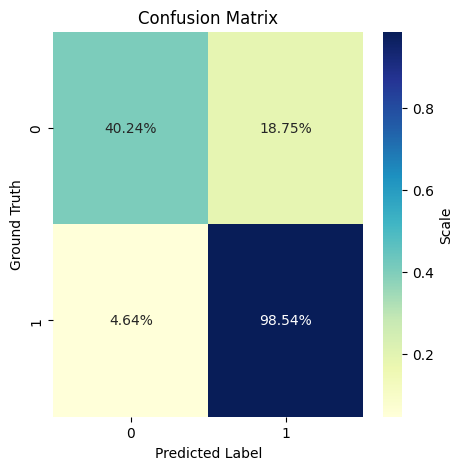

模型準確率: 84.62%
模型F1分數: 90.70%
流失玩家中，模型可以抓到的比例: 98.54%
模型認為的流失玩家中，真正為流失的比例: 84.01%



In [83]:
def plot_confusion_matrix(data):
    plt.figure(1, figsize = (5, 5)) 
    plt.title("Confusion Matrix")
    
    sns.color_palette(palette = "mako")
    
    ax = sns.heatmap(data, annot=True, fmt='.2%', cmap="YlGnBu", cbar_kws={'label': 'Scale'})
 
    ax.set(ylabel="Ground Truth", xlabel="Predicted Label")
 
    plt.show() 
    
Y_pred = model_xgb.predict(X_train_dm)

cfMatrix = confusion_matrix(Y_train, Y_pred)
plot_confusion_matrix(data = cfMatrix/ cfMatrix.sum(axis = 1))

accuracy = accuracy_score(Y_train, Y_pred)
f1 = f1_score(Y_train, Y_pred)
recall = recall_score(Y_train, Y_pred)
precision = precision_score(Y_train, Y_pred)

print(f'模型準確率: {accuracy:.2%}', end = '\n')
print(f'模型F1分數: {f1:.2%}', end = '\n')
print(f'流失玩家中，模型可以抓到的比例: {recall:.2%}', end = '\n')
print(f'模型認為的流失玩家中，真正為流失的比例: {precision:.2%}', end = '\n\n')

#### 測試資料集

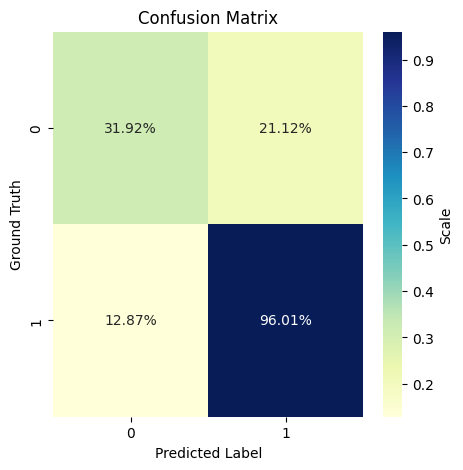

模型準確率: 80.83%
模型F1分數: 88.43%
流失玩家中，模型可以抓到的比例: 96.01%
模型認為的流失玩家中，真正為流失的比例: 81.97%



In [84]:
Y_pred = model_xgb.predict(X_test_dm)

cfMatrix = confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(data = cfMatrix/ cfMatrix.sum(axis = 1))

accuracy = accuracy_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)

print(f'模型準確率: {accuracy:.2%}', end = '\n')
print(f'模型F1分數: {f1:.2%}', end = '\n')
print(f'流失玩家中，模型可以抓到的比例: {recall:.2%}', end = '\n')
print(f'模型認為的流失玩家中，真正為流失的比例: {precision:.2%}', end = '\n\n')

In [85]:
print("Model feature names:", model_xgb.feature_names) #放入使用模型

Model feature names: ['前第0周登入次數', '前第2周單周報酬率', '前第0周平均日遊玩時間長度', '前第1周儲值金額', '是否於近6個月註冊_否', '前第1周平均日遊玩時間長度', '前第1周遊玩天數', '前第2周運營的發生次數', '前1月遊玩時間長度的周斜率', '前1月單周報酬率的周斜率', '下載平台_Google Play', '前第0周登入贈送的發生次數', '前1月限時活動的金幣變化的周斜率', '前第0周平台贈送的發生次數', '前第1周平均日登入次數', '前1月登入贈送的發生次數的周斜率', '前1月總贏金幣的周斜率', '前第1周登入贈送的金幣變化', '前第1周遊戲的發生次數', '前第1周單周報酬率', '前1月遊戲的金幣變化的周斜率', '是否於觀察期註冊_是', '前第0周遊玩天數', '前1月平均日登入次數的周斜率', '前1月道具的金幣變化的周斜率', '前1月登入天數的周斜率', '前第2周登入次數', '前第2周平均日遊玩時間長度', '前第2周平均日登入次數', '前第0周單周報酬率']
